# Visualization
This is a notebook that demonstrate the use of visualization function with time-moe model as an example

We load the model and dataset as usual, except that we also output the **processed_inputs**, which is the input that actually get inputed into the model after truncation from the model pipeline.

In [ ]:
import os
import json
from dotenv import load_dotenv
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR


from gluonts.model import evaluate_model
from gluonts.time_feature import get_seasonality
from gift_eval.data import Dataset
from gluonts.itertools import batcher
from gluonts.model.forecast import QuantileForecast, SampleForecast

from typing import List, Union, Tuple
import torch.nn.functional as F

from gluonts.itertools import batcher
from transformers import AutoModelForCausalLM
from dataset_utils import download_boom_benchmark

boom_path = "ChangeMe"
download_boom_benchmark(boom_path)
load_dotenv()

dataset_properties_map = json.load(open("./boom/boom_properties.json"))
all_datasets = list(dataset_properties_map.keys())
print(len(all_datasets))    

In [ ]:
class timemoe_wrapper:
    def __init__(self, prediction_length, truncate = 1000, batch_size = 1000):
        model_name = "/foundation-models-research/toto/time-series-foundation-models/time-moe/"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device_map = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map = self.device, trust_remote_code=True)
        self.batch_size = batch_size
        self.truncate = truncate
        self.prediction_length = prediction_length
    def calculate_max_shape(self, values: List[Union[torch.Tensor, np.ndarray]]) -> Tuple[int, ...]:
            """Calculate the maximum shape for a list of tensors or arrays."""
            return tuple(
                max(v.size(dim) if isinstance(v, torch.Tensor) else v.shape[dim] for v in values)
                for dim in range(len(values[0].shape))
            )

    def pad_and_stack(self, values: List[Union[torch.Tensor, np.ndarray]], max_shape: Tuple[int, ...]) -> torch.Tensor:
        """Pad and stack tensors or arrays to the given max shape."""
        padded_values: List[torch.Tensor] = [
            (
                F.pad(
                    v,
                    [
                        value
                        for dim, max_dim in enumerate(reversed(max_shape))
                        for value in (0, max_dim - (v.size(dim) if isinstance(v, torch.Tensor) else v.shape[dim]))
                    ],
                )
                if isinstance(v, torch.Tensor)
                else torch.tensor(
                    np.pad(
                        v, [(0, max_dim - v.shape[dim]) for dim, max_dim in enumerate(max_shape)], mode="constant"
                    )
                )
            )
            for v in values
        ]
        return torch.stack(padded_values)
    
    def truncate_and_stack(self, tensor_list, maxlength):
        """
        Truncates each tensor to maxlength. If a tensor is shorter than maxlength, it is left-padded with zeros.
        Uses torch.jit.fork to parallelize the extraction and padding process.
        
        Args:
            tensor_list (list of torch.Tensor): List of tensors with shape (length) or (num_channel, length).
            maxlength (int): The fixed length to truncate or pad tensors.
        
        Returns:
            torch.Tensor: Stacked tensor with shape (N, maxlength) for 1D tensors or (N, num_channel, maxlength) for 2D tensors.
        """
        def process_tensor(t):
            # t = self.normalize_input(t)
            if t.dim() == 1:
                pad_size = maxlength - t.shape[0]
                if pad_size > 0:
                    t = torch.cat([torch.zeros(pad_size, dtype=t.dtype, device=t.device), t])
                return t[-maxlength:]
            else:
                pad_size = maxlength - t.shape[1]
                if pad_size > 0:
                    t = torch.cat([torch.zeros(t.shape[0], pad_size, dtype=t.dtype, device=t.device), t], dim=1)
                return t[:, -maxlength:]
        
        futures = [torch.jit.fork(process_tensor, t) for t in tensor_list]  # Parallel extraction and padding
        extracted_tensors = [torch.jit.wait(f) for f in futures]  # Wait for all to complete
        return torch.stack(extracted_tensors, dim=0)  # Stack along first dimension
    def normalize_input(self, inputs):
        mean, std = inputs.mean(dim=-1, keepdim=True), inputs.std(dim=-1, keepdim=True)
        normed_input = (inputs - mean) / std
        return normed_input, mean, std
    def predict(self, data):
        self.model.eval()
        self.model = self.model.to(self.device)
        while self.batch_size>=1:
            try:
                print("Trying batch size", self.batch_size)
                forecasts = []
                process_inputs = []
                for batch in batcher(data, batch_size=self.batch_size):
                    inputs = [torch.tensor(entry["target"]) for entry in batch]
                    if not self.truncate:
                        max_shape = self.calculate_max_shape(inputs)
                        padded_input = self.pad_and_stack(inputs, max_shape)
                    else:
                        padded_input = self.truncate_and_stack(inputs, self.truncate)
                    if len(padded_input.shape)>2:
                        padded_input = padded_input.squeeze(1)
                    padded_input = padded_input.to(self.device).float()
                    process_inputs.append(padded_input.cpu().numpy())
                    padded_input, means, stds = self.normalize_input(padded_input)
                    # print(padded_input.shape)
                    with torch.no_grad():
                        output = self.model.generate(padded_input, max_new_tokens=self.prediction_length)
                        output = output*stds+means
                    forecasts.append(output[:, -self.prediction_length:].cpu().numpy())
                forecasts = np.concatenate(forecasts)
                process_inputs = np.concatenate(process_inputs)
                break
            except RuntimeError:
                self.batch_size = self.batch_size//2
                print(f"Batch size too large, reducing to {self.batch_size}")
        if self.batch_size < 1:
            raise ValueError("Batch size too small")
        
        forecasts_date = []
        for item, ts in zip(forecasts, data):
            item = item[np.newaxis,:]
            # print(item.shape)
            forecast_start_date = ts["start"] + len(ts["target"])

            forecasts_date.append(SampleForecast(samples=item, start_date=forecast_start_date))

        return forecasts_date, process_inputs

Now we run the pipeline on one dataset and get the forecast on that dataset for visualization

In [11]:
from gift_eval.data import Dataset
import torch

torch.set_float32_matmul_precision("high")

for ds_name in all_datasets:
    ds_key = ds_name.split("/")[0]
    print(f"Processing dataset: {ds_name}")
    terms = ["long"]
    for term in terms:
        to_univariate = False if Dataset(name=ds_name, term=term,to_univariate=False).target_dim == 1 else True
        dataset = Dataset(name=ds_name, term=term, to_univariate=to_univariate)
        model = timemoe_wrapper(dataset.prediction_length)
        forecasts, process_inputs = model.predict(dataset.test_data.input)

Processing dataset: bizitobs_l2c/H
Trying batch size 1000


Here we import the visualization function from the destination path. Note that the parameters that the function takes is described as follows:

- **forecasts**: list of forecast (SampleForecast, QuantileForecast, or list like iterables)
    expected shape of forecast[i] to be (num_samples, num_steps, num_variate) for gluonts sample object or (num_variate, num_steps) for numpy array
- **process_inputs**: list of processed input samples
- **dataset**: dataset object
- **xlim**: tuple of x-axis limits, support only 1 element in the tuple as the left bound
- **ylim**: tuple of y-axis limits, support only 1 element in the tuple as the bottom bound
- **num_pictures**: list of indices of pictures to plot
- **verbose**: whether to print out specifics of the plots
- **fig_size**: figure size for each of the plot
- **confidence**: the confidence for the CI internval that we want show for probablistic forecasts, range (0,1).

In [ ]:
import importlib.util


# Define full path to the module
module_path = "/foundation-models-research-eval/toto/eval/gift_eval/notebooks/vis_forecast.py"
module_name = "vis_forecast"

# Load the module
spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

visualize = module.visualize

SampleForecast object detected
Number of variate is: 0
Total number of pictures is: 7
shape of raw input is: (1944,)
shape of processed input is: (1000,)
shape of label is: (720,)
shape of forecast is: (720,)
shape of upper bound is: (720,)
shape of lower bound is: (720,)
shape of raw input is: (1944,)
shape of processed input is: (1000,)
shape of label is: (720,)
shape of forecast is: (720,)
shape of upper bound is: (720,)
shape of lower bound is: (720,)
shape of raw input is: (1944,)
shape of processed input is: (1000,)
shape of label is: (720,)
shape of forecast is: (720,)
shape of upper bound is: (720,)
shape of lower bound is: (720,)
shape of raw input is: (1944,)
shape of processed input is: (1000,)
shape of label is: (720,)
shape of forecast is: (720,)
shape of upper bound is: (720,)
shape of lower bound is: (720,)
shape of raw input is: (1944,)
shape of processed input is: (1000,)
shape of label is: (720,)
shape of forecast is: (720,)
shape of upper bound is: (720,)
shape of lo

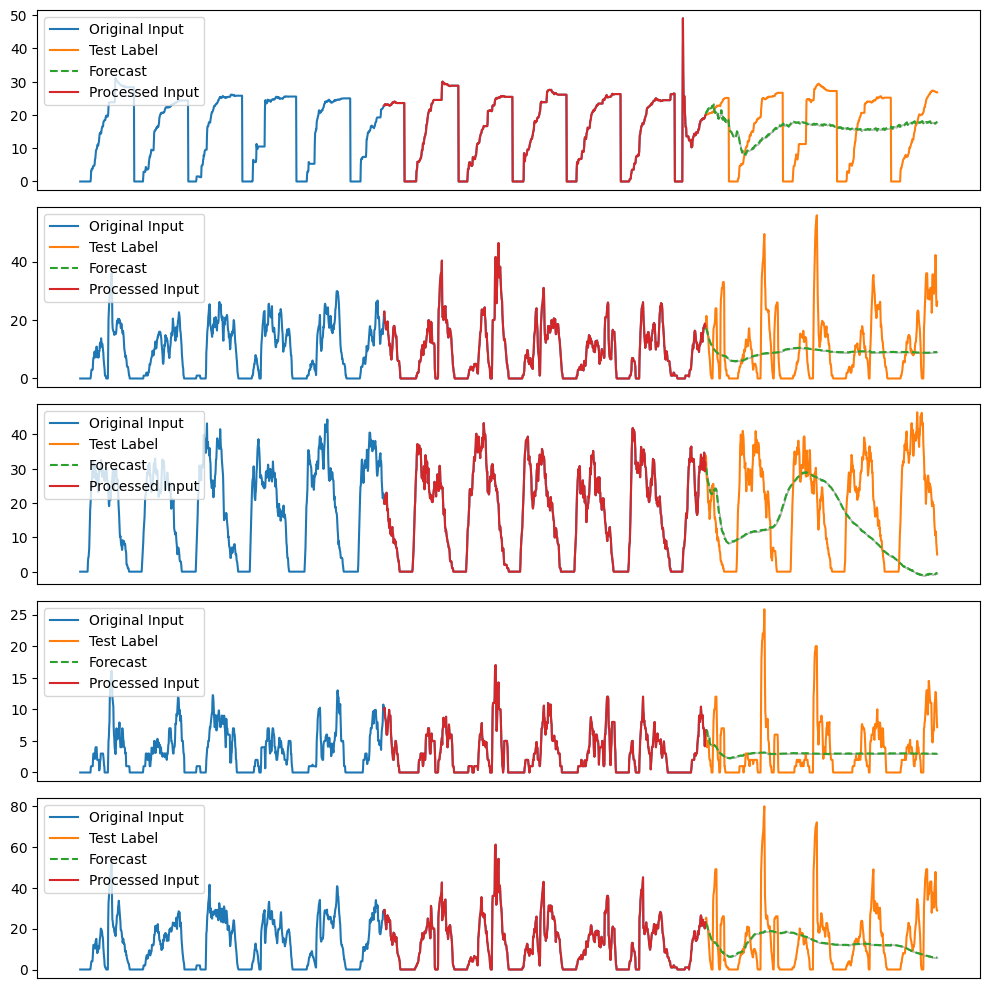

In [17]:
visualize(forecasts, dataset, process_inputs, num_pictures=[i for i in range(5)])